In [1]:
import requests
import json
from deepeval.dataset import EvaluationDataset
from tqdm import tqdm
import requests
import re
from typing import List, Dict, Tuple, Any
import pandas as pd
from deepeval import evaluate
from deepeval.test_case import LLMTestCase
from custom_metrics import get_dataset, custom_answer_relevancy_metric, custom_faithfulness_metric, custom_contextual_relevancy_metric, correctness_metric

from tqdm import tqdm
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import time
import toml
with open('config.toml', 'r', encoding='utf-8') as toml_file:
    config = toml.load(toml_file)

model_names = config['model_names']
alter_names = model_names.copy()

INPUT_EXCEL_FILE = "goldens" / Path(config['QA_file_name'])
question_dfs = pd.read_excel(INPUT_EXCEL_FILE, sheet_name=None, index_col=0)
DOMAIN = list(question_dfs.keys())
from util import get_QA_from_different_models
QA_df = get_QA_from_different_models()

In [ ]:
def rag_query_and_process(query: str, max_retries: int = 3, retry_delay: int = 1) -> Tuple[List[Dict[str, Any]], str]:
    """
    Sends a query to a RAG API, processes the streaming response, extracts the retrieved
    text chunks and the final generated answer. Retries the request on failure.

    Args:
        query (str): The user's question (e.g., "氘氚的来源是什么？").
        max_retries (int): The maximum number of times to retry the request.
        retry_delay (int): The delay in seconds between retries.

    Returns:
        Tuple[List[Dict[str, Any]], str]: A tuple containing:
            - A list of dictionaries, where each dictionary represents a retrieved text chunk.
            - A string containing the final answer generated by the model.
            Returns ([], "") if an error occurs after all retries or no relevant chunks are found.
    """
    # api_url = 'http://supiedt.com:39080/api/admin/app/pythonKnowledge/knowledgeChat'
    api_url = 'http://219.148.159.170:30081/admin/app/pythonKnowledge/knowledgeChat'
    auth_token = 'e763abdda2d5b80800ad9bc3a0e8679a'
    # auth_token = '7a187cce3e79c84fd5f8cc5002ac1e6d'
    headers = {
        'Content-Type': 'application/json',
        'Authorization': auth_token
    }

    # The payload for the API request
    data = {
        'modelId': "1932788697049075712",
        'modelType': "public",
        'tempChatSetStrId': "7a187cce3e79c84fd5f8cc5002ac1e6d",
        'conversationId': "7a187cce3e79c84fd5f8cc5002ac1e6d",
        'query': query,
        'chatSetStrId': "7a187cce3e79c84fd5f8cc5002ac1e6d",
        'agentId': "1922906834805460992",
        'answerPattern': "normal_mode",
        'knowledgeRetrieverConfig': {
            'roleDirectives': "你是一名资深聚变等离子体物理与工程专家，熟悉托卡马克、仿星器及相关理论-实验-工程全链路知识。  \n对接下来出现的任何单独问题，请遵循以下答题规范输出答案：\n\n1. **核心结论** —— 用一句话先给出最直接的结论或结果。  \n2. **背景与概念** —— 说明问题所涉及的物理/工程背景，清晰给出关键概念、符号定义及单位。  \n3. **原理与推导 / 机理分析**  \n   - 若题目需要理论推导：逐步列出主要方程，并在每一步写出所用假设或近似。  \n   - 若题目聚焦机理或装置：描述关键过程，说明影响该过程的主要物理量或控制参数。  \n4. **定量估算或示例** —— 当题目包含数值条件或“估算”“计算”字样时，给出计算步骤、插入典型参数并得到数值结果；否则可用典型参数区间作量级估算。  \n5. **工程或实验意义** —— 指出结论对聚变装置设计、运行控制、诊断、材料或安全的具体启示。  \n6. **比较与拓展（如适用）** —— 若存在多种模型/方案/观点，列出优缺点并给出适用条件。  \n7. **要点总结** —— 用 1-2 句话重申最重要的信息或建议。\n\n**写作要求**  \n- 语言：正文中文，可保留国际通用英文缩写与符号。  \n- 结构：使用清晰的小标题或项目符号，便于快速阅览。  \n- 方程：用 LaTeX 语法 `$ ... $` 书写，标注各符号含义。  \n- 单位：在首次出现的物理量后给出规范单位。  \n- 如题干信息不足以得到唯一答案，请先阐明必要假设或指出需要进一步信息。  \n- 保持严谨、客观，不输出未经验证的猜测。\n\n仅按上述规范作答；除问题正文外，无需提及题目类别、难易度或本提示词自身。",
            'knowledgeIdList': [202505161116],
            'memoryJudge': "5",
            'knowledgeHeightConfig': {
                'isOpenContext': True,
                'topK': 5,
                'score': 0.7,
                'retrievalStrategy': "hybrid",
                'rerankModelConfig': {"modelId":"1922304470893465600","modelType":"public","modelName":"bge-reranker-v2-m3"},
            },
            'top_k': 5,
            'score': 0.7,
            'retrieval_strategy': "hybrid"
        }
    }

    retrieved_chunks = []
    final_answer = ""
    
    for attempt in range(max_retries):
        is_stream_complete = False
        try:
            # Use stream=True and verify=False to process the request
            # A timeout is added as a safeguard against hanging requests.
            with requests.post(api_url, headers=headers, json=data, stream=True, verify=False, timeout=60) as response:
                response.raise_for_status()  # Will still check for 4xx or 5xx errors

                # Read the stream line by line
                for line in response.iter_lines():
                    if line:
                        decoded_line = line.decode('utf-8')
                        if decoded_line.startswith('data:'):
                            json_str = decoded_line[len('data:'):].strip()
                            if json_str == '[DONE]':
                                is_stream_complete = True
                                break
                            
                            try:
                                data_chunk = json.loads(json_str)
                                result = data_chunk.get('data', {}).get('result', {})
                                
                                if result.get('is_completion'):
                                    is_stream_complete = True
                                
                                content_list = result.get('content', [])
                                for item in content_list:
                                    outputs = item.get('outputs', {})
                                    event_type = item.get('event_type')
                                    event_status = item.get('event_status')

                                    # Check for the retrieved text chunks
                                    if (event_type == 'default_rag_agent' and
                                        event_status == 'running' and
                                        'references' in outputs and
                                        isinstance(outputs['references'], list)):
                                        
                                        for ref_chunk in outputs['references']:
                                            if 'chunk_text' in ref_chunk:
                                                clean_chunk = {
                                                    'score': ref_chunk.get('score'),
                                                    'file_name': ref_chunk.get('file_name'),
                                                    'chunk_text': ref_chunk.get('chunk_text'),
                                                    'source_documents': ref_chunk.get('chunk_metadata', {}).get('Source_documents')
                                                }
                                                retrieved_chunks.append(clean_chunk)
                                    
                                    # Check for the final answer
                                    if (event_type == 'default_rag_agent' and
                                        event_status == 'done' and
                                        'references' in outputs):
                                        final_answer = outputs.get('references', '')

                            except json.JSONDecodeError as e:
                                print(f"Error decoding JSON from line: {decoded_line}. Error: {e}")

            # If we have successfully processed the stream, break the retry loop and return
            if is_stream_complete:
                return retrieved_chunks, final_answer

        except requests.exceptions.RequestException as e:
            print(f"Attempt {attempt + 1} of {max_retries} failed: {e}")
            if attempt + 1 < max_retries:
                print(f"Retrying in {retry_delay} seconds...")
                time.sleep(retry_delay)
            else:
                print("All retry attempts failed.")
                return [], ""  # Return empty result on final error

    # This part is reached if the loop completes without a successful request
    # (e.g., the server connects but sends an incomplete stream).
    return retrieved_chunks, final_answer

# --- Usage Example ---
if __name__ == '__main__':
    # Replace with your actual API details
    QUERY = '氘和氚的区别是什么？'

    print(f"Sending query: '{QUERY}' to the API...")
    
    chunks, answer = rag_query_and_process(QUERY)
    
    if chunks:
        print("\n" + "="*50)
        print("🔎 **Retrieved Text Chunks:**")
        print("="*50)
        for i, chunk in enumerate(chunks):
            print(f"**Chunk {i + 1} (Score: {chunk['score']:.4f})**")
            print(f"  **Source File:** {chunk.get('file_name', 'N/A')}")
            print(f"  **Text:**\n{chunk['chunk_text']}\n")
    else:
        print("\nNo text chunks were retrieved.")
        
    if answer:
        print("\n" + "="*50)
        print("💡 **Final Generated Answer:**")
        print("="*50)
        print(answer)
    else:
        print("\nNo final answer was generated.")

Sending query: '氘和氚的区别是什么？' to the API...


In [ ]:

questions = ['氘氚的区别是什么？','DT反应的产物是什么？']
RAG_cases = []
for question in tqdm(questions):
    chunks, answer = rag_query_and_process(question)
    if not chunks:
        continue
    RAG_cases.append(LLMTestCase(
        input=question,
        actual_output=answer,
        retrieval_context=[chunk['chunk_text'] for chunk in chunks],
    ))
evaluation_output = evaluate(
    test_cases=RAG_cases,
    metrics=[custom_answer_relevancy_metric, custom_faithfulness_metric, custom_contextual_relevancy_metric]
    )
answer_relevancy_scores = np.array([evaluation_output.test_results[k].metrics_data[0].score for k in range(len(evaluation_output.test_results))])
faithfulness_scores = np.array([evaluation_output.test_results[k].metrics_data[1].score for k in range(len(evaluation_output.test_results))])
contextual_relevancy_scores = np.array([evaluation_output.test_results[k].metrics_data[2].score for k in range(len(evaluation_output.test_results))])

100%|██████████| 2/2 [00:38<00:00, 19.11s/it]


✨ You're running DeepEval's latest 回答相关性 [GEval] Metric! (using DeepSeek-R1-0528-AWQ (JSON), strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest 忠实性 [GEval] Metric! (using DeepSeek-R1-0528-AWQ (JSON), strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest 上下文相关性 [GEval] Metric! (using DeepSeek-R1-0528-AWQ (JSON), strict=False, 
async_mode=True)...

Output()



Metrics Summary

  - ✅ 回答相关性 [GEval] (score: 1.0, threshold: 0.5, strict: False, evaluation model: DeepSeek-R1-0528-AWQ (JSON), reason: 实际输出直接回答了DT反应的产物是什么，核心结论部分明确给出了产物是高能α粒子和高能中子，后续内容围绕产物展开解释，未引入无关信息。输出结构清晰，符合科学严谨性要求，且全部使用简体中文陈述。, error: None)
  - ✅ 忠实性 [GEval] (score: 1.0, threshold: 0.5, strict: False, evaluation model: DeepSeek-R1-0528-AWQ (JSON), reason: 实际回答基于召回的文本块，准确陈述了DT反应的产物是α粒子和中子，与检索上下文中的信息一致。回答未添加矛盾事实，且结构清晰，符合所有评估步骤要求。, error: None)
  - ✅ 上下文相关性 [GEval] (score: 0.7, threshold: 0.5, strict: False, evaluation model: DeepSeek-R1-0528-AWQ (JSON), reason: 召回的文本块包含DT反应产物的信息（如氦核和alpha粒子），但部分文本块（如第三个）侧重中子辐射和铀反应，与输入问题关联较弱。整体上，文本块有助于回答，但存在不相关信息。, error: None)

For test case:

  - input: DT反应的产物是什么？
  - actual output: 核心结论  
—— DT反应（氘-氚聚变反应）的产物是一个高能α粒子（氦核，$^4$He）和一个高能中子^[1]^。

背景与概念  
- DT反应指的是氘（D，$^2$H）与氚（T，$^3$H）发生的核聚变反应。
- 标准反应式：  
  $$
  ^2\mathrm{H} + ^3\mathrm{H} \rightarrow ^4\mathrm{He}~(3.5\,\mathrm{MeV}) + n~(14.1\,\mathrm{MeV})
  $$
  其中，$\alpha$粒子即$^4$He核，中子为$n$。

原理与机

✓ Tests finished 🎉! Run 'deepeval view' to analyze, debug, and save evaluation results on Confident AI.

In [ ]:
print(f"Answer Relevancy Scores: {answer_relevancy_scores}")
print(f"Faithfulness Scores: {faithfulness_scores}")
print(f"Contextual Relevancy Scores: {contextual_relevancy_scores}")

Answer Relevancy Scores: [1.  0.8]
Faithfulness Scores: [1. 1.]
Contextual Relevancy Scores: [0.7 0.8]


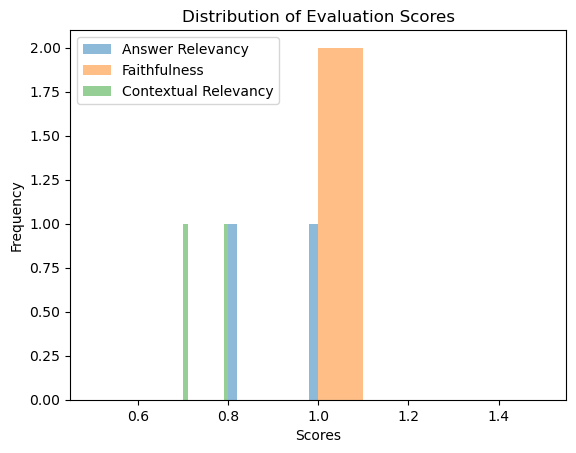

In [ ]:
plt.hist(answer_relevancy_scores, label='Answer Relevancy', alpha=0.5)
plt.hist(faithfulness_scores, label='Faithfulness', alpha=0.5)
plt.hist(contextual_relevancy_scores, label='Contextual Relevancy', alpha=0.5)
plt.xlabel('Scores')
plt.ylabel('Frequency')
plt.title('Distribution of Evaluation Scores')
plt.legend()
plt.show()

In [ ]:
Golden_questions = []
import json
with open('goldens/golden_questions.jsonl', 'r', encoding="utf-8") as f:
    for line in f:
        data = json.loads(line)
        Golden_questions.append(data['问题'])
print(len(Golden_questions))
print(Golden_questions[0])

130
如何从单粒子运动轨迹理论出发，推导并解释磁镜约束的基本原理及其对聚变装置设计的意义？讨论绝热不变量在其中的作用和失效条件。


In [ ]:
RAG_cases = []
for question in tqdm(Golden_questions):
    chunks, answer = rag_query_and_process(question)
    if not chunks:
        continue
    RAG_cases.append(LLMTestCase(
        input=question,
        actual_output=answer,
        retrieval_context=[chunk['chunk_text'] for chunk in chunks],
    ))
RAG_dataset = EvaluationDataset(test_cases=RAG_cases)


  2%|▏         | 2/130 [01:16<1:22:23, 38.62s/it]

Attempt 1 of 3 failed: HTTPConnectionPool(host='127.0.0.1', port=7890): Read timed out.
Retrying in 1 seconds...


 24%|██▍       | 31/130 [20:09<1:05:20, 39.60s/it]

Attempt 1 of 3 failed: Response ended prematurely
Retrying in 1 seconds...


 49%|████▉     | 64/130 [43:32<35:01, 31.84s/it]  

Attempt 1 of 3 failed: HTTPConnectionPool(host='127.0.0.1', port=7890): Read timed out.
Retrying in 1 seconds...


100%|██████████| 130/130 [1:23:27<00:00, 38.52s/it]


In [ ]:
RAG_dataset.save_as(file_type="json", directory="./RAG-test-dataset", include_test_cases=True)

Evaluation dataset saved at ./RAG-test-dataset/20250701_123749.json!


'./RAG-test-dataset/20250701_123749.json'

In [2]:
RAG_test_dataset = EvaluationDataset()
RAG_test_dataset.add_test_cases_from_json_file(
    file_path='./RAG-test-dataset/20250701_123749.json',
    input_key_name="input",
    actual_output_key_name="actual_output",
    expected_output_key_name="expected_output",
    retrieval_context_key_name="retrieval_context",
    context_key_name="context",
)

In [3]:
print(len(RAG_test_dataset.test_cases))

130


In [4]:
evaluation_output = evaluate(
    RAG_test_dataset.test_cases,
    metrics=[
        custom_answer_relevancy_metric, 
        custom_faithfulness_metric,
        custom_contextual_relevancy_metric
        ]
    )
answer_relevancy_scores = np.array([evaluation_output.test_results[k].metrics_data[0].score for k in range(len(evaluation_output.test_results))])
faithfulness_scores = np.array([evaluation_output.test_results[k].metrics_data[1].score for k in range(len(evaluation_output.test_results))])
contextual_relevancy_scores = np.array([evaluation_output.test_results[k].metrics_data[2].score for k in range(len(evaluation_output.test_results))])

✨ You're running DeepEval's latest 回答相关性 [GEval] Metric! (using DeepSeek-R1-0528-AWQ (JSON), strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest 忠实性 [GEval] Metric! (using DeepSeek-R1-0528-AWQ (JSON), strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest 上下文相关性 [GEval] Metric! (using DeepSeek-R1-0528-AWQ (JSON), strict=False, 
async_mode=True)...

Output()



Metrics Summary

  - ✅ 回答相关性 [GEval] (score: 1.0, threshold: 0.5, strict: False, evaluation model: DeepSeek-R1-0528-AWQ (JSON), reason: 实际输出完全回答了输入中的两个问题：准确计算了Spitzer电阻率的值（约1.1×10^{-7} Ω·m），并明确说明经典电阻贡献通常占70-90%，超额部分引出反常电阻概念。输出紧扣等离子体物理领域，未包含无关信息。, error: None)
  - ✅ 忠实性 [GEval] (score: 1.0, threshold: 0.5, strict: False, evaluation model: DeepSeek-R1-0528-AWQ (JSON), reason: 实际回答基于召回的文本块生成，包含Spitzer电阻率计算公式、数值估算过程及反常电阻概念，且所有事实与召回的文本块一致，如Spitzer电阻率与温度的关系、数值计算结果、反常电阻的来源等均无矛盾。, error: None)
  - ✅ 上下文相关性 [GEval] (score: 0.6, threshold: 0.5, strict: False, evaluation model: DeepSeek-R1-0528-AWQ (JSON), reason: 召回的文本块包含Spitzer电阻率公式和相关讨论，但部分内容与输入问题关联度不高，例如hot-tail机制和环电压测量细节。有效信息如电阻率与温度关系及反常电阻概念被提及，但未直接回答比例问题。, error: None)

For test case:

  - input: 估算在典型托卡马克等离子体参数下（如电子温度 Te​=5keV，电子密度 ne​=1020m−3，有效电荷数 Zeff​=2），Spitzer电阻率的值。并讨论与实验观测到的环电压相比，经典电阻的贡献通常占多大比例，这如何引出反常电阻的概念？
  - actual output: 核心结论  
—— 在 $T_e = 5\,\mathrm{keV}$、$n_e = 10^{20}\,\mathrm{m}^{-3}$、$Z_{\rm eff} = 2$ 的托卡马克等离子体中，Spitzer

✓ Tests finished 🎉! Run 'deepeval view' to analyze, debug, and save evaluation results on Confident AI.

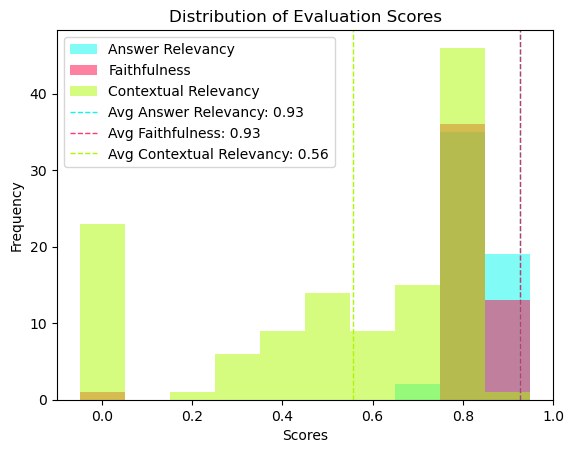

In [5]:
answer_relevancy_color = "#03F9ECFA"
faithfulness_color = "#FF0447C9"
contextual_relevancy_color = "#ADF800"

bin_edges = np.arange(-0.05, 1.05, 0.1)
plt.hist(answer_relevancy_scores, bins=bin_edges, label='Answer Relevancy', color=answer_relevancy_color, alpha=0.5)
plt.hist(faithfulness_scores, bins=bin_edges, label='Faithfulness', color=faithfulness_color, alpha=0.5)
plt.hist(contextual_relevancy_scores, bins=bin_edges, label='Contextual Relevancy', color=contextual_relevancy_color, alpha=0.5)
average_answer_relevancy = np.mean(answer_relevancy_scores)
average_faithfulness = np.mean(faithfulness_scores)
average_contextual_relevancy = np.mean(contextual_relevancy_scores)
plt.axvline(average_answer_relevancy, color=answer_relevancy_color, linestyle='dashed', linewidth=1, label=f'Avg Answer Relevancy: {average_answer_relevancy:.2f}')
plt.axvline(average_faithfulness, color=faithfulness_color, linestyle='dashed', linewidth=1, label=f'Avg Faithfulness: {average_faithfulness:.2f}')
plt.axvline(average_contextual_relevancy, color=contextual_relevancy_color, linestyle='dashed', linewidth=1, label=f'Avg Contextual Relevancy: {average_contextual_relevancy:.2f}')
plt.xlabel('Scores')
plt.ylabel('Frequency')
plt.title('Distribution of Evaluation Scores')
plt.legend()
plt.show()

In [6]:
evaluation_output_df = pd.DataFrame(
    [
        {
            "input": evaluation_output.test_results[i].input,
            "actual_output": evaluation_output.test_results[i].actual_output,
            "expected_output": evaluation_output.test_results[i].expected_output,
            "answer_relevancy_score": evaluation_output.test_results[i].metrics_data[0].score,
            "answer_relevancy_reason": evaluation_output.test_results[i].metrics_data[0].reason,
            "faithfulness_score": evaluation_output.test_results[i].metrics_data[1].score,
            "faithfulness_reason": evaluation_output.test_results[i].metrics_data[1].reason,
            "contextual_relevancy_score": evaluation_output.test_results[i].metrics_data[2].score,
            "contextual_relevancy_reason": evaluation_output.test_results[i].metrics_data[2].reason,
        } 
    for i in range(len(evaluation_output.test_results))
    ])
output_path = Path("./RAG-results")
evaluation_output_file_name = Path(f"RAG-results.parquet")
evaluation_output_df.to_parquet(output_path / evaluation_output_file_name)

In [7]:
evaluation_output_df[evaluation_output_df['contextual_relevancy_score'] < 0.4]['contextual_relevancy_reason'].to_list()

['召回的文本块未直接提及Mercier判据和气球模判据在仿星器中的应用，也未解释为何在仿星器中满足局部判据后仍需进行全局分析。文本块主要讨论Newcomb方程和托卡马克中的稳定性条件，与输入问题无关。',
 '召回的文本块与输入问题无关。输入要求描述等离子体鞘层的形成过程和主要特征，但文本块讨论的是静电探针与等离子体边界鞘层的不同，以及鞘层厚度等细节，未涉及形成过程和德拜鞘层、预鞘层等特征。此外，未提及鞘层在等离子体与壁相互作用或朗缪尔探针中的角色，因此内容无助于回答输入问题。',
 '召回的文本块中，第一块提及了气球模和剥离气球模，但未详细说明驱动机制或对约束的影响；第二块和第三块重复且仅简要提到扭曲模和气球模的分类，未深入解释；第四块为英文片段，未提供具体机制；第五块为项目计划表格，无具体物理内容。整体未能提供足够信息回答输入问题。',
 '召回的文本块中只有第三块提到了仿星器的三维效应和计算复杂性，但未涉及MHD稳定性分析的具体挑战或VMEC、CAS3D程序的作用。其他文本块完全不相关，例如第一块讨论TFTR实验，第二块涉及其他代码分类，第四和第五块重复第三块内容且包含无关的磁镜装置信息。输入要求讨论特殊挑战和计算程序作用，但召回内容未提供相关信息，因此所有文本块均不符合要求。',
 '召回的文本块重复且不完整，未提供ELMs定义、主要类型（如Type-I）、对等离子体约束和第一壁的影响，也未提及ITER装置中ELM控制策略（如RMP、颗粒注入）。',
 '召回文本块主要讨论漂移波不稳定性（如ITG/TEM）和L-H转换，与输入问题部分相关（微观漂移波不稳定性），但未涉及宏观MHD不稳定性（如Kink模）的比较。文本块未提供驱动机制、时间尺度或对等离子体影响的直接对比信息。',
 '召回的文本块与输入问题无关，输入问题涉及托卡马克等离子体启动阶段的最小环向电场估算和中心螺线管磁通变化量推导，但召回文本讨论壁处理、ICRF技术、粒子分类、球形托卡马克特性等，未直接提供所需公式或推导相关信息。',
 '召回文本块中仅第五段提及等离子体加热和驱动系统，但未具体说明总体要求；其他文本块讨论混合堆、DEMO设计细节或等离子体约束问题，与输入问题要求的效率、可靠性、可维护性及与氚增殖包层兼容性等具体方面关联不足。',
 '召回的文本块提及灰尘可能导致爆炸，与输入问题部分

In [8]:
evaluation_output_df[evaluation_output_df['faithfulness_score']<0.5]['faithfulness_reason'].to_list()

['实际回答完全聚焦于纯聚变堆DEMO的等离子体加热与电流驱动系统要求，但检索上下文明确指出测试案例要求只研究纯聚变堆，而实际回答未提及混合堆内容且未区分纯聚变与混合堆差异，导致事实矛盾。']

In [9]:
import json
with open('goldens/QA_goldens.jsonl', 'r', encoding="utf-8") as f:
    goldens_QA = [json.loads(line) for line in f]
print(len(goldens_QA))

130


In [10]:
for i, case in enumerate(RAG_test_dataset.test_cases):
    assert case.input == goldens_QA[i]['问题']
    case.expected_output = goldens_QA[i]['参考答案']

In [11]:
correctness_evaluation_output = evaluate(
    RAG_test_dataset.test_cases,
    metrics=[correctness_metric]
    )
RAG_correctness_scores = np.array([correctness_evaluation_output.test_results[k].metrics_data[0].score for k in range(len(correctness_evaluation_output.test_results))])
RAG_correctness_evaluation_output_df = pd.DataFrame(
    [
        {
            "input": correctness_evaluation_output.test_results[i].input,
            "actual_output": correctness_evaluation_output.test_results[i].actual_output,
            "expected_output": correctness_evaluation_output.test_results[i].expected_output,
            "score": correctness_evaluation_output.test_results[i].metrics_data[0].score,
            "reason": correctness_evaluation_output.test_results[i].metrics_data[0].reason,
        }
    for i in range(len(correctness_evaluation_output.test_results))
    ])

✨ You're running DeepEval's latest 正确率 [GEval] Metric! (using DeepSeek-R1-0528-AWQ (JSON), strict=False, 
async_mode=True)...

Output()



Metrics Summary

  - ✅ 正确率 [GEval] (score: 1.0, threshold: 0.5, strict: False, evaluation model: DeepSeek-R1-0528-AWQ (JSON), reason: 实际输出完全覆盖了预期输出的核心结论、背景概念、原理分析、定量估算、工程意义、比较拓展和要点总结，且所有物理量和公式一致。输出中增加的参考文献标引和具体细节与问题相关且不影响结论，符合评价标准。, error: None)

For test case:

  - input: 什么是反常输运？详细讨论一种主要的微观不稳定性（如离子温度梯度模ITG）是如何驱动反常输运的，包括其线性增长和非线性饱和机制。
  - actual output: 核心结论  
—— 反常输运是指磁约束等离子体中的能量和粒子输运显著高于经典和新经典理论预测，主要由微观不稳定性诱发的湍流驱动；其中离子温度梯度模（ITG）是典型的反常输运驱动机制，其通过线性漂移波不稳定性增长、非线性模式耦合与饱和过程导致大幅增强的横向输运^[2][3][5]^。

背景与概念  
- 反常输运（Anomalous transport）：实验中观测到的能量、粒子或动量损失远超经典（碰撞主导）和新经典（考虑磁漂移）输运的理论预期。
- 经典/新经典输运：由库仑碰撞、磁漂移等粒子随机运动导致的低水平输运，理论上可精确计算。
- 微观不稳定性：等离子体中由压力/温度/密度梯度等驱动的小尺度（与Larmor半径同量级）扰动。
- 反常输运的量度：如热导率、扩散系数等，实际值常为经典理论预测的10–100倍^[3][5]^。

原理与机理分析  
1. **离子温度梯度模（ITG）驱动反常输运机理**  
   - ITG模是一类以离子温度径向梯度为自由能源的电磁漂移波微不稳定性，当$|\nabla T_i|$超过临界阈值时被激发^[2]^。
   - 其扰动频率和增长率与离子漂移频率、Larmor半径及温度梯度相关。

2. **线性增长阶段**  
   - 线性理论框架下，ITG模增长率$\gamma$与离子温度梯度成正比，满足条件
     $$
     \eta_i = \frac{L_n}{L_{T_i}} > \eta_{i, \text

✓ Tests finished 🎉! Run 'deepeval view' to analyze, debug, and save evaluation results on Confident AI.

In [12]:
inference_model = "openai/gpt-4.1"
reference_answer = "openai/o3"
baseline_dataset = get_dataset(
        infer_model=inference_model,
        ref_model=reference_answer,
        QA_dataframe=QA_df,
        domains=DOMAIN
    )
baseline_correctness_evaluation_output = evaluate(
    baseline_dataset,
    metrics=[correctness_metric]
)
baseline_correctness_scores = np.array([baseline_correctness_evaluation_output.test_results[k].metrics_data[0].score for k in range(len(baseline_correctness_evaluation_output.test_results))])

✨ You're running DeepEval's latest 正确率 [GEval] Metric! (using DeepSeek-R1-0528-AWQ (JSON), strict=False, 
async_mode=True)...

Output()



Metrics Summary

  - ✅ 正确率 [GEval] (score: 0.6, threshold: 0.5, strict: False, evaluation model: DeepSeek-R1-0528-AWQ (JSON), reason: 实际输出提供了正确的色散关系公式和频率计算，但未包含离子等离子体频率贡献，且在ICRH描述中未明确使用L波共振。推导思路与预期相近但结论表述不完整。, error: None)

For test case:

  - input: 推导均匀磁化冷等离子体中平行传播的右旋圆偏振电磁波（R波）和左旋圆偏振电磁波（L波）的色散关系。在此基础上，估算典型托卡马克参数下（如B0​=2T, ne​=5×1019m−3）电子回旋频率和离子回旋频率，并讨论ECRH和ICRH分别利用了哪些波的共振特性。
  - actual output: ### 核心结论
在均匀磁化冷等离子体中，平行传播的右旋圆偏振电磁波（R波）和左旋圆偏振电磁波（L波）的色散关系可分别表示为 $n^2 = 1 - \frac{\omega_{pe}^2}{(\omega - \Omega_{ce})\omega}$ 和 $n^2 = 1 - \frac{\omega_{pe}^2}{(\omega + \Omega_{ce})\omega}$。

### 背景与概念
- 在等离子体中，电磁波传播受到等离子体频率和磁场的影响，常用等离子体色散关系描述波的传播特性。
- **R波**：右旋圆偏振（Right circularly polarized wave）电磁波。
- **L波**：左旋圆偏振（Left circularly polarized wave）电磁波。
- **等离子体频率** $\omega_{pe}$：$\omega_{pe} = \sqrt{\frac{n_e e^2}{\varepsilon_0 m_e}}$，其中 $e$ 是电子电荷，$m_e$ 是电子质量，$\varepsilon_0$ 是真空电容率，$n_e$ 是电子密度。
- **电子回旋频率** $\Omega_{ce}$：$\Omega_{ce} = \frac{e B_0}{m_e}$，$B_0$ 是磁场强度。
- **离子回旋频率** $\Omega_{ci

✓ Tests finished 🎉! Run 'deepeval view' to analyze, debug, and save evaluation results on Confident AI.

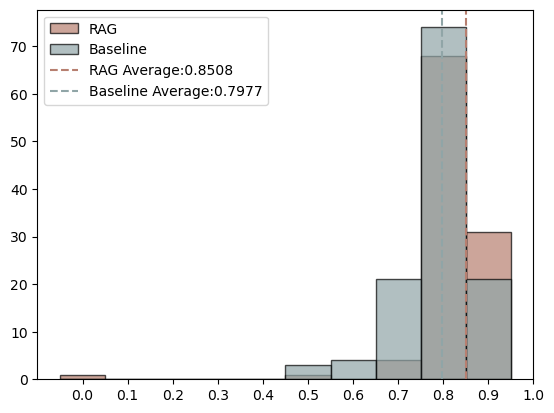

In [13]:
morandi_red = '#B77F70'
morandi_blue = '#90A5A7'

RAG_average_score = np.mean(RAG_correctness_scores)
baseline_average_score = np.mean(baseline_correctness_scores)
plt.hist(RAG_correctness_scores, bins=bin_edges, label='RAG', edgecolor='black', alpha=0.7, color=morandi_red)
plt.hist(baseline_correctness_scores, bins=bin_edges, label='Baseline', edgecolor='black', alpha=0.7, color=morandi_blue)
plt.xticks(np.arange(0, 1.1, 0.1))
plt.axvline(RAG_average_score, color=morandi_red, linestyle='--', label=f'RAG Average:{RAG_average_score:.4f}')
plt.axvline(baseline_average_score, color=morandi_blue, linestyle='--', label=f'Baseline Average:{baseline_average_score:.4f}')
plt.legend()
plt.show()

In [14]:
from IPython.display import display, Markdown



def display_markdown_answer(md_string, title):
    display(Markdown(f"# {title}\n" + md_string))

worse_cases = RAG_correctness_evaluation_output_df[RAG_correctness_evaluation_output_df['score'] < 0.5]
for case in worse_cases.to_dict(orient='records'):
    display_markdown_answer(case['input'], "Input")
    display_markdown_answer(case['actual_output'], "Actual Output")
    display_markdown_answer(case['expected_output'], "Reference Answer")
    display_markdown_answer(f"Score: {case['score']}", "Score")
    print("-" * 50)  # 分隔线
    display_markdown_answer(case['reason'], "Reason")
    print("-" * 50)  # 分隔线

# Input
简述一种主流的MHD模拟程序（如NIMROD, JOREK, M3D-C1）的特点及其在聚变等离子体稳定性（如破裂、ELMs）研究中的应用实例。

# Actual Output
核心结论  
—— NIMROD 是一种主流的3D磁流体力学（MHD）模拟程序，具备高效求解等离子体大尺度演化和不稳定性的能力，广泛应用于托卡马克破裂（disruption）、边界局域模（ELM）等现象的数值研究与理论验证^[2]^。

一、背景与概念  
- **NIMROD (Non-Ideal MHD with Rotation – Open Discussion)**：专为磁约束等离子体设计的三维非理想MHD数值模拟平台，可模拟等离子体在复杂几何下的时空演化。
- **MHD稳定性**：等离子体大尺度集体行为的稳定性，包括破裂（disruption）、ELMs（边缘局域模）等关键物理过程。

二、程序特点  
- **物理模型**：NIMROD 基于单流体或双流体MHD方程组，支持电阻性、粘滞性、有限Larmor半径、热输运等非理想效应建模。
- **数值算法**：采用有限元与谱方法结合，高效处理复杂装置边界和三维几何；具备自适应网格与并行计算能力。
- **多物理场耦合**：可与杂质输运、阻尼、外部加热等模型耦合，适用于多种聚变装置和物理场景^[2]^。

三、聚变等离子体稳定性研究应用实例  
1. **托卡马克破裂模拟**  
   - NIMROD 可模拟等离子体破裂前后电流分布、磁场结构演化，研究破裂触发机制、扰动传播路径及等离子体响应。
   - 支持外部扰动线圈、磁扰动等工程手段对破裂的影响分析。
2. **ELMs与边界不稳定性**  
   - 能精确再现由电流梯度、压力梯度驱动的peeling-ballooning型边界不稳定，分析ELMs的触发、发展与非线性演化过程。
   - 可与杂质输运模型联用，模拟ELMs期间杂质注入对等离子体热负荷的缓解作用^[1][2]^。
3. **破裂缓解与控制方案评估**  
   - NIMROD 可与破裂缓解物理模型（如杂质注入、磁扰动等）耦合，评估不同工程方案对MHD不稳定性的抑制效果^[2]^。

四、工程与实验意义  
- 支持实验方案设计与优化，为托卡马克如ITER等装置的安全运行、主动控制提供理论依据。
- 有助于理解和预测关键MHD不稳定现象，为聚变堆工程化提供数据支撑。

五、要点总结  
—— NIMROD可高效模拟托卡马克等离子体的破裂与ELMs等MHD不稳定性，在理论分析、实验对比及控制方案评估等领域发挥重要作用，是当前聚变等离子体数值研究的核心工具之一^[2][1]^。

---
^[1]^ NIMROD、M3D-C1、JOREK等3D MHD代码可模拟托卡马克等离子体演化，适用于破裂、ELMs等现象的动力学分析。  
^[2]^ NIMROD、M3D-C1、JOREK等3D MHD代码是聚变装置破裂模拟的主力工具，能与杂质输运、辐射、动力学等子模型耦合，实现多物理场联合模拟。

# Reference Answer
**1. 核心结论**  
MHD模拟程序如JOREK能高效描述托卡马克边缘局域及全三维大扰动，广泛用于ELMs、破裂等等离子体稳定性问题的数值研究，是聚变等离子体控制与优化不可或缺的工具。

---

### 2. 背景与概念

- **MHD模拟程序**利用磁流体动力学（MHD）方程求解等离子体中流体、磁场、电流等大尺度行为。
- 程序如**JOREK**（专注于托卡马克边缘区域异常，如ELMs）、**NIMROD**（非结构网格，适用多几何）、**M3D-C1**（高阶有限元，适合等离子体全域三维动态）。
- *ELM*（Edge Localized Mode，边缘局域模）：H模（高约束）等离子体边界常见的MHD不稳定。
- *Disruption*（破裂）：等离子体发生快速能量、位形损失的严重MHD失稳事件。

---

### 3. 原理与机制分析（以JOREK为例）

- **JOREK特点**
  - 求解不可压磁流体动力学方程组（可选两流体效应）：
    $$
    \frac{\partial \rho}{\partial t} + \nabla \cdot (\rho \mathbf{v}) = 0
    $$
    $$
    \rho \left( \frac{\partial \mathbf{v}}{\partial t} + \mathbf{v} \cdot \nabla \mathbf{v} \right) = -\nabla p + \mathbf{j} \times \mathbf{B} + \cdots
    $$
    - $ \rho $：密度 (kg/m$^3$)
    - $ \mathbf{v} $：速度 (m/s)
    - $ \mathbf{j} $：电流密度 (A/m$^2$)
    - $ \mathbf{B} $：磁场 (T)
  - 采用**二维极坐标网格**，在环向采用傅里叶分解，适合等离子体边界复杂形变。
  - 可模拟X点、分离器结构，真实反映托卡马克偏滤器/刮削层物理。
- **整体适用流程**
  - 前处理：基于Equilibrium（如EFIT输出）读取初始位形
  - 引入物理扰动（如密度/温度梯度）
  - 非线性演化求解，输出磁场结构、扰动增长率、能量耗散等信息。

---

### 4. 定量示例与应用

- **ELM模拟实例（JOREK）**
  - 以JET或ITER参数：
    - 主要半径$R_0 \sim 3$ m，电流 $I_p \sim 15$ MA，磁场 $B_t \sim 5$ T。
    - 输入实验测得的压力剖面，引入初始微小扰动。
    - 得到ELM触发、非线性爆发、等离子体能量/粒子损失的时间演化。
    - 可输出ELM能量损失$\Delta W/W_{ped}$的定量结果（典型为5%-20%）。
- **破裂模拟**
  - JOREK和其他MHD代码用于模拟破裂前缘MHD活动、预测锁模岛形成，进而模拟热猝发（thermal quench）与电流猝发（current quench）阶段。
  - 有助于理解控制线圈或密度泵入等破裂缓解/避免机理。

---

### 5. 工程或实验意义

- 实现**ELM行为预测与缓解**方案设计（如RMP线圈参数优化、ELM pacing方案选取）。
- 辅助**破裂诊断、预警和工程防护**（如热负荷评估、第一壁与偏滤器稳健性验证）。
- 为等离子体运行窗口分析提供理论支持，提升工程运行安全裕度。

---

### 6. 比较与拓展

- **JOREK**
  - 优势：高效处理边界/偏滤器三维结构、ELM等复杂边界不稳定。
  - 劣势：核心等离子体高阶局部结构分辨率有限。
- **NIMROD**
  - 优势：适应各种几何、流体与慢速粒子动力学耦合、适合全域破裂模拟。
  - 劣势：边界结构细致刻画相对弱。
- **M3D-C1**
  - 优势：高阶有限元，面向全三维、多理物建模。
  - 劣势：计算量/资源消耗大，对网格/初始条件设置要求高。

---

### 7. 要点总结

MHD模拟程序（如JOREK）是破解ELM、破裂等聚变等离子体稳定性关键问题的必备利器，其多物理、三维、非线性仿真能力不断推动聚变装置运行优化与失稳抑制对策的发展。

# Score
Score: 0.0

--------------------------------------------------


# Reason
实际输出核心结论聚焦于NIMROD，但预期输出要求以JOREK为例，两者核心程序不一致；推导思路相似但结论不同，违反步骤3；且实际输出未涵盖预期中的公式、物理量及定量实例，违反步骤4。

--------------------------------------------------


In [79]:
deepeval_metrics_evaluation_output_df = pd.read_parquet("RAG-results/evaluation_output_of_RAG.parquet")

In [80]:
deepeval_metrics_evaluation_output_df.head()

input  \
0  自由边界MHD不稳定性与固定边界不稳定性有何区别？真空区和理想导电壁的存在如何影响外部扭曲模...   
1  论述磁流体力学（MHD）近似的适用条件及其局限性。在哪些聚变等离子体现象的研究中，必须超越M...   
2  阐述理想磁流体力学（MHD）的基本方程组，并解释其核心物理假设。如何利用能量原理分析等离子体...   
3  讨论仿星器MHD稳定性分析的特殊挑战，例如三维效应和缺乏连续对称性。简述VMEC和CAS3D...   
4  解释Mercier判据和气球模判据在仿星器局部稳定性评估中的应用。为何在仿星器中，即使局部判...   

                                       actual_output  \
0  核心结论  \n—— 自由边界MHD不稳定性允许等离子体边界随扰动移动，易激发外部扭曲模（外...   
1  核心结论  \n—— MHD近似适用于时空尺度远大于离子回旋尺度、等离子体接近完全电中性、碰...   
2  核心结论  \n—— 理想磁流体力学（MHD）基本方程组包括连续性方程、动量方程、状态方程和...   
3  核心结论  \n—— 仿星器MHD稳定性分析面临三维磁场结构和缺乏连续对称性等独特挑战，需采...   
4  核心结论  \n—— Mercier判据和气球模判据用于评估仿星器等离子体在每个磁通量面上的...   

                                     expected_output  \
0  ### 1. 核心结论\n\n固定边界与自由边界MHD不稳定性区别主要在于边界条件对扰动模态...   
1  **1. 核心结论**  \n磁流体力学（MHD）近似适用于空间尺度远大于Larmor半径、...   
2  1. 核心结论  \n理想磁流体力学（ideal MHD）用一组描述理想导电流体与电磁场相互...   
3  **核心结论**  \n仿星器的三维磁场结构和缺乏连续对称性，使其MHD稳定性分析面临独特挑...   
4  **核心结论**  \nMercier判据和气球模（ballooning mode）判据用于...   

                                   retrieval_context  answer_relevancy_score  \
0  [在未来先进托卡马克运行模式下（Advanced Tokamak Scenarios），由于...                1.000000   
1  [以上方程中出现的物理量定义为质量密度：\rho=\sum_{s}m_{s}n_{s}=m_...                1.000000   
2  [时尤其有用。在一个实验中，如果这个边界被违反（超出），快速增长的不稳定甚至会引起放电的熄灭...                1.000000   
3  [modes (KBM) is discussed. The TAE mode is pre...                1.000000   
4  [这就是Newcomb方程。Newcomb方程的一个重要特性是其在f(r)=0的有理面上变得...                0.766667   

   faithfulness_score  contextual_relevancy_score  contextual_recall_score  
0            1.000000                    0.357143                 1.000000  
1            1.000000                    0.285714                 1.000000  
2            1.000000                    0.261905                 0.857143  
3            1.000000                    0.333333                 0.473684  
4            0.956522                    0.416667                 1.000000

In [81]:
deepeval_answer_relevancy_scores = deepeval_metrics_evaluation_output_df['answer_relevancy_score'].to_list()
deepeval_faithfulness_scores = deepeval_metrics_evaluation_output_df['faithfulness_score'].to_list()
deepeval_contextual_relevancy_scores = deepeval_metrics_evaluation_output_df['contextual_relevancy_score'].to_list()
deepeval_contextual_recall_scores = deepeval_metrics_evaluation_output_df['contextual_recall_score'].to_list()

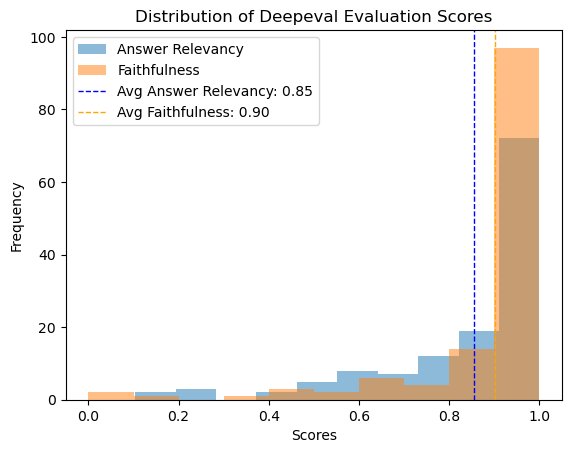

In [83]:
mean_deepeval_answer_relevancy = np.mean(deepeval_answer_relevancy_scores)
mean_deepeval_faithfulness = np.mean(deepeval_faithfulness_scores)
mean_deepeval_contextual_relevancy = np.mean(deepeval_contextual_relevancy_scores)
mean_deepeval_contextual_recall = np.mean(deepeval_contextual_recall_scores)

plt.hist(deepeval_answer_relevancy_scores, label='Answer Relevancy', alpha=0.5)
plt.hist(deepeval_faithfulness_scores, label='Faithfulness', alpha=0.5)

plt.axvline(mean_deepeval_answer_relevancy, color='blue', linestyle='dashed', linewidth=1, label=f'Avg Answer Relevancy: {mean_deepeval_answer_relevancy:.2f}')
plt.axvline(mean_deepeval_faithfulness, color='orange', linestyle='dashed', linewidth=1, label=f'Avg Faithfulness: {mean_deepeval_faithfulness:.2f}')

plt.xlabel('Scores')
plt.ylabel('Frequency')
plt.title('Distribution of Deepeval Evaluation Scores')
plt.legend()
plt.show()

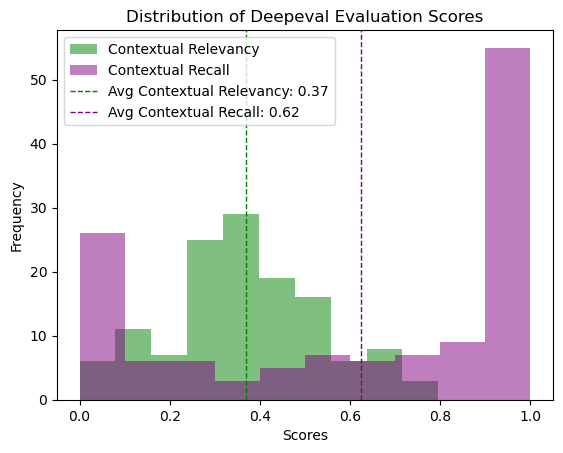

In [85]:
plt.hist(deepeval_contextual_relevancy_scores, label='Contextual Relevancy', alpha=0.5, color='green')
plt.hist(deepeval_contextual_recall_scores, label='Contextual Recall', alpha=0.5, color='purple')

plt.axvline(mean_deepeval_contextual_relevancy, color='green', linestyle='dashed', linewidth=1, label=f'Avg Contextual Relevancy: {mean_deepeval_contextual_relevancy:.2f}')
plt.axvline(mean_deepeval_contextual_recall, color='purple', linestyle='dashed', linewidth=1, label=f'Avg Contextual Recall: {mean_deepeval_contextual_recall:.2f}')

plt.xlabel('Scores')
plt.ylabel('Frequency')
plt.title('Distribution of Deepeval Evaluation Scores')
plt.legend()
plt.show()